# XGBoost Visualization Notebook

### Library Import Station

In [5]:
!pip install shap

In [6]:
!pip install plotly

In [7]:
import sys
import types
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize

sns.set(style="whitegrid", font_scale=1.15)

### Loading pickle

In [8]:
# Create a fake xgboost package with full submodule structure

# Main xgboost module
fake_xgb = types.ModuleType("xgboost")

# Submodules
fake_core = types.ModuleType("xgboost.core")
fake_sklearn = types.ModuleType("xgboost.sklearn")

# Fake Booster class (because your model contains one)
class FakeBooster:
    def __init__(self, *args, **kwargs):
        pass
    def __setstate__(self, state):
        # accept whatever state pickle gives
        self.__dict__.update(state)

fake_core.Booster = FakeBooster

# Fake XGBClassifier class
class FakeXGBClassifier:
    def __init__(self, *args, **kwargs):
        pass
    def __setstate__(self, state):
        self.__dict__.update(state)

fake_sklearn.XGBClassifier = FakeXGBClassifier

# Register the modules in sys.modules so pickle can find them
sys.modules["xgboost"] = fake_xgb
sys.modules["xgboost.core"] = fake_core
sys.modules["xgboost.sklearn"] = fake_sklearn

# Also register submodules inside the fake main module so attribute access works
fake_xgb.core = fake_core
fake_xgb.sklearn = fake_sklearn

print("Fake xgboost modules registered successfully.")

# --------- Now safely load your bundle ---------
bundle_path = "../../Results/Pickle_Bundles/xgb_bundle.pkl"

with open(bundle_path, "rb") as f:
    bundle = pickle.load(f)

print("Bundle keys:", bundle.keys())

Fake xgboost modules registered successfully.
Bundle keys: dict_keys(['model_name', 'y_test', 'y_pred', 'y_proba', 'confusion_matrix', 'accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'log_loss', 'roc_auc_ovr', 'params', 'xgb_feature_importance_gain', 'xgb_feature_names', 'xgb_shap_values', 'xgb_shap_expected_value', 'xgb_shap_X', 'feature_names', 'X_test_sample', 'xgb_best_model'])


In [9]:
# ---- Extract what we need from the bundle ----
y_test  = bundle["y_test"]                      # encoded labels (0,1,2)
y_pred  = bundle["y_pred"]
y_proba = bundle["y_proba"]
cm      = bundle["confusion_matrix"]

feature_names       = bundle["feature_names"]   # numpy array of names
xgb_gain_importance = bundle["xgb_feature_importance_gain"]
X_test_sample       = bundle["X_test_sample"]

xgb_shap_values         = bundle["xgb_shap_values"]
xgb_shap_expected_value = bundle["xgb_shap_expected_value"]
X_shap                  = bundle["xgb_shap_X"]

# Encoded classes in this model
encoded_classes = np.sort(np.unique(y_test))
print("Encoded classes:", encoded_classes)

# Map encoded labels back to original DIABETE4 codes:
# 0 -> 1 (No diabetes), 1 -> 3 (Prediabetes), 2 -> 4 (Diabetes)
enc_to_orig = {0: 1, 1: 3, 2: 4}
display_labels = [enc_to_orig[c] for c in encoded_classes]
print("Display labels:", display_labels)


Encoded classes: [0 1 2]
Display labels: [1, 3, 4]


### Figure 1: Confusion Matrix

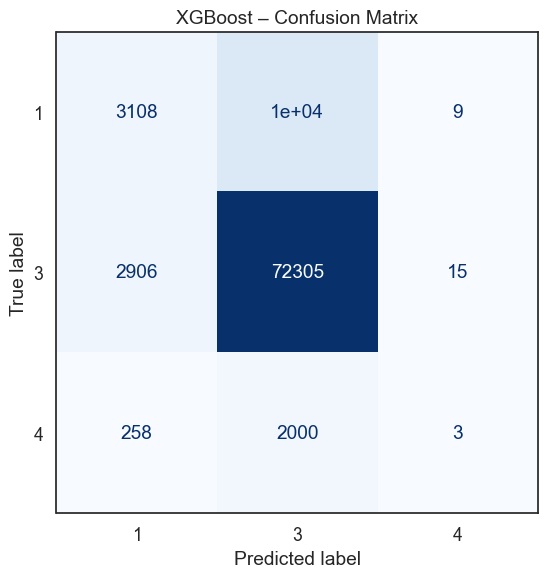

In [10]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(6, 6))

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=display_labels
)
disp.plot(cmap="Blues", colorbar=False, ax=ax)
ax.grid(False)

ax.set_title("XGBoost – Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

plt.tight_layout()
# plt.savefig("../../Results/Visualizations/xgb_confusion_matrix.png",
#             dpi=300, bbox_inches="tight")
plt.show()


### Confusion Matrix (Multiclass)

This confusion matrix shows how well the tuned XGBoost model distinguishes between the three diabetes-related classes:

- **Class 1** → No diabetes  
- **Class 3** → Pre-diabetic  
- **Class 4** → Diagnosed diabetes  

The diagonal boxes represent correct predictions.  
XGBoost performs strongest on **Class 3**, correctly identifying most pre-diabetic individuals.  
Classes 1 and 4 see more misclassification, which reflects the overlapping health/lifestyle patterns in the dataset.


### Figure 2: ROC Curve

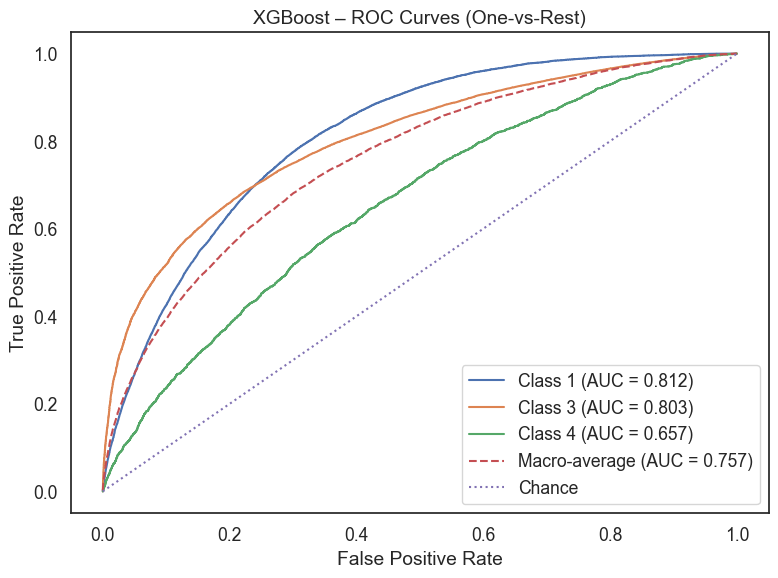

In [11]:
classes_enc = encoded_classes
n_classes = len(classes_enc)

# One-vs-rest binarization
y_test_bin = label_binarize(y_test, classes=classes_enc)

fpr, tpr, roc_auc = {}, {}, {}

for i, cls_enc in enumerate(classes_enc):
    fpr[cls_enc], tpr[cls_enc], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[cls_enc] = auc(fpr[cls_enc], tpr[cls_enc])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[c] for c in classes_enc]))
mean_tpr = np.zeros_like(all_fpr)
for c in classes_enc:
    mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
mean_tpr /= n_classes
roc_auc["macro"] = auc(all_fpr, mean_tpr)

plt.figure(figsize=(8, 6))

for c in classes_enc:
    orig = enc_to_orig.get(c, c)
    plt.plot(fpr[c], tpr[c],
             label=f"Class {orig} (AUC = {roc_auc[c]:.3f})")

plt.plot(all_fpr, mean_tpr, linestyle="--",
         label=f"Macro-average (AUC = {roc_auc['macro']:.3f})")
plt.plot([0, 1], [0, 1], linestyle=":", label="Chance")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost – ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right")
plt.tight_layout()
# plt.savefig("../../Results/Visualizations/xgb_roc_curves.png",
#             dpi=300, bbox_inches="tight")
plt.show()


### ROC Curves (One-vs-Rest)

The ROC curves evaluate how well the model separates each class from the others using predicted probabilities.

- **AUC ≈ 0.81 for Class 1** → Strong discrimination  
- **AUC ≈ 0.80 for Class 3** → Also strong  
- **AUC ≈ 0.66 for Class 4** → Harder to classify due to smaller sample size and overlapping signals  
- **Macro-AUC ≈ 0.76** → Overall probability quality across all classes

Curves closer to the top-left corner indicate better predictive power.  
XGBoost demonstrates **robust performance**, especially for distinguishing non-diabetic vs. pre-diabetic individuals.


### Figure 3: Gain-Based Feature Importance

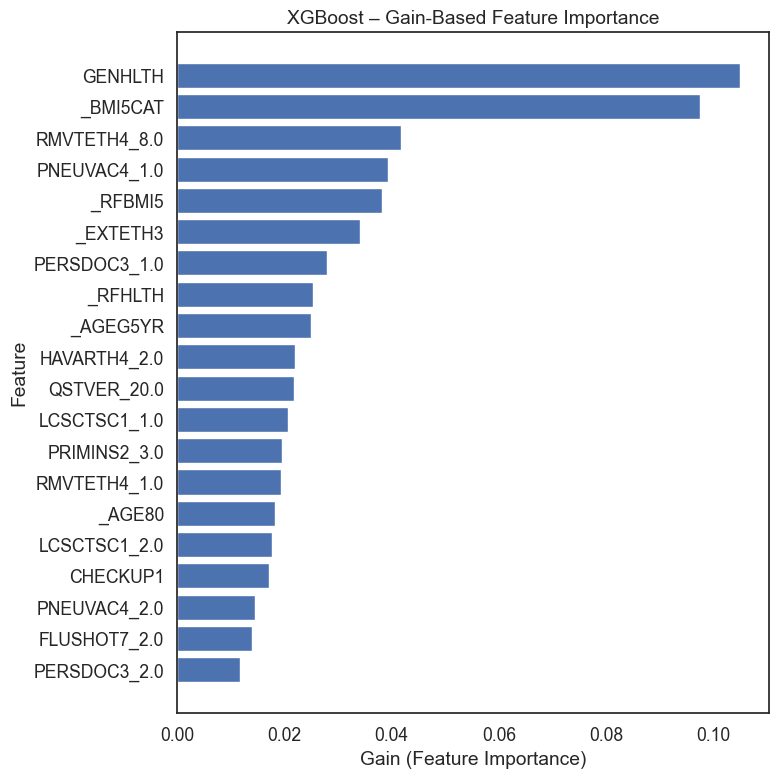

In [12]:
# Sort by gain (descending)
indices = np.argsort(xgb_gain_importance)[::-1]
top_n = 20
top_idx = indices[:top_n]

plt.figure(figsize=(8, 8))
plt.barh(
    y=np.array(feature_names)[top_idx],
    width=xgb_gain_importance[top_idx]
)
plt.gca().invert_yaxis()

plt.xlabel("Gain (Feature Importance)")
plt.ylabel("Feature")
plt.title("XGBoost – Gain-Based Feature Importance")
plt.tight_layout()
# plt.savefig("../../Results/Visualizations/xgb_gain_importance.png",
#             dpi=300, bbox_inches="tight")
plt.show()


### XGBoost – Gain-Based Feature Importance

This plot shows the features that contributed the most to XGBoost’s decision-making, measured by **gain** —  
how much each feature improved the model’s splits.

Top-ranked features such as **GENHLTH** (general health), **_BMI5CAT** (BMI category), and **RMVTETH4_8.0**  
have the highest gain values, meaning they frequently created informative splits in the trees.

These features represent broad health, demographic, and lifestyle factors that strongly influence diabetes risk.


### Figure 4: SHAP Value plot

/opt/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SHAP values shape for plot: (2000, 198)


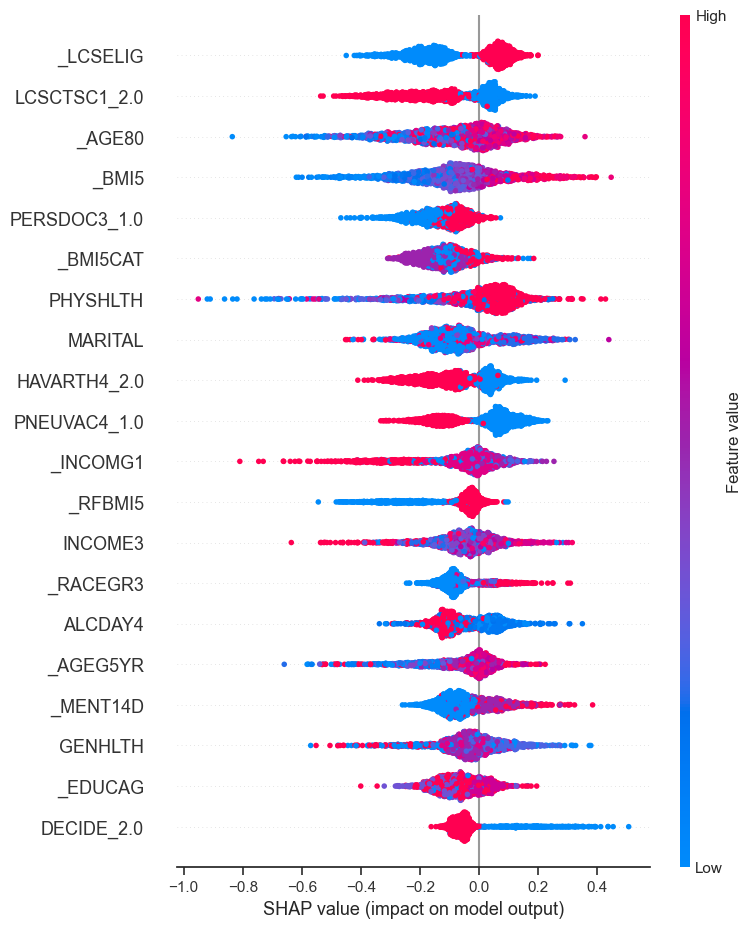

In [13]:
import shap
shap.initjs()

if xgb_shap_values is None or X_shap is None:
    raise ValueError("xgb_shap_values or X_shap is None in the bundle – "
                     "SHAP could not be computed when saving the bundle.")

# ---- Handle different shapes of xgb_shap_values ----
if isinstance(xgb_shap_values, list):
    # classic multiclass case: list of (n_samples, n_features)
    shap_vals_for_plot = xgb_shap_values[2]      # diabetes class (encoded 2)
elif xgb_shap_values.ndim == 3:
    # your case: (n_samples, n_features, n_classes)
    shap_vals_for_plot = xgb_shap_values[:, :, 2]   # slice diabetes class
else:
    # already (n_samples, n_features)
    shap_vals_for_plot = xgb_shap_values

print("SHAP values shape for plot:", shap_vals_for_plot.shape)

# ---- Proper SHAP Summary Plot (dot) ----
shap.summary_plot(
    shap_vals_for_plot,
    X_shap,
    feature_names=feature_names,
    plot_type="dot",
    max_display=20
)


### SHAP Summary Plot (Feature Impact)

This SHAP plot explains how each feature influences the model’s prediction for the diabetes class.

- Each point represents one person in the dataset  
- **X-axis**: SHAP value → how much that feature pushed the prediction higher or lower  
- **Color**: Feature value (blue = low, red = high)  

Patterns reveal relationships:
- High values of features like **_LCSELIG**, **_AGE80**, and **PERSDOC3_1.0** push predictions toward diabetes  
- Some features show opposite behavior, with high values reducing risk  
- The vertical spread shows variability and uncertainty in how features affect different individuals  

SHAP gives human-interpretable insight into *why* XGBoost predicts diabetes for each case.


In [14]:
# Compute top 20 features by mean |SHAP|
import pandas as pd
mean_abs_shap = np.abs(shap_vals_for_plot).mean(axis=0)

fi_top = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False).head(20)

### Figure 5: Interactive SHAP

In [16]:
# PRETTY RENDERER
import plotly.io as pio
pio.renderers.default = "iframe_connected"  


# Interactive SHAP Bar Chart


fig = px.bar(
    fi_top,
    x="mean_abs_shap",
    y="feature",
    orientation="h",
    title="<b>XGBoost — Top 20 Features by Mean |SHAP| (Diabetes Class)</b>",
    labels={
        "mean_abs_shap": "Mean |SHAP| Value (impact on model output)",
        "feature": "Feature"
    },
    color="mean_abs_shap",
    color_continuous_scale="Blues",   # prettier than default
    hover_data={"mean_abs_shap": ':.4f'},
)

# STYLE IMPROVEMENTS
fig.update_layout(
    template="plotly_white",
    title_font=dict(size=26, family="Arial", color="#333"),
    font=dict(size=15, family="Arial"),
    coloraxis_showscale=False,       # hide color bar for cleaner look
    xaxis_title_font=dict(size=18),
    yaxis_title_font=dict(size=18),
    xaxis=dict(gridcolor="rgba(0,0,0,0.1)", zeroline=False),
    yaxis=dict(autorange="reversed"), # largest on top
    bargap=0.4,                       # spacing between bars
)

# Rounded bars (only works in Plotly >5.16)
fig.update_traces(marker_line_width=0, marker_line_color="rgba(0,0,0,0)",
                  marker=dict(cornerradius=6))  # cute rounded edges

fig.show()

# Save PNG
fig.write_image("../../Results/Visualizations/Final_visualizations/XGB_Interactive_SHAP_plot.png")

# -----------------------------
# Embed Interpretation in HTML
# -----------------------------
html_content = fig.to_html(
    include_plotlyjs="cdn",
    full_html=True
)

interpretation_html = """
<div style="margin-top: 20px; font-family: Arial; font-size: 15px; line-height: 1.6;">
    <h3>Interpretation: XGBoost SHAP Feature Importance</h3>
    <p>
    This interactive bar chart displays the top 20 features ranked by their mean absolute SHAP values, 
    revealing which variables have the strongest influence on XGBoost’s diabetes predictions. Higher SHAP 
    values indicate features that consistently shift the model's output. Lifestyle and healthcare access 
    indicators such as <b>_LCSELIG</b>, <b>_AGE80</b>, and having a personal doctor show large contributions, 
    while physical health factors (BMI, activity levels), socioeconomic conditions (income, education), 
    and medical history also play substantial roles. Hovering over each bar reveals the precise magnitude 
    of each feature's effect.
    </p>
</div>
"""

# Combine plot + interpretation
final_html = html_content.replace("</body>", interpretation_html + "</body>")

# Save HTML
with open("../../docs/XGB_plot.html", "w") as f:
    f.write(final_html)


### Top 20 Features by Mean |SHAP| (Interactive)

This interactive bar chart ranks the top 20 features by **mean absolute SHAP value**,  
showing which factors have the greatest overall impact on diabetes predictions.

Higher |SHAP| values mean a feature consistently influences the model’s output.

Key insights:
- Lifestyle and medical access indicators such as **_LCSELIG**, **_AGE80**, and **PERSDOC3_1.0**  
  have the strongest influence.
- Features related to physical health (BMI, physical activity), social determinants (income, education),  
  and medical history also play large roles.

Hovering over each bar reveals precise SHAP impact values.
